In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [2]:
import logging
import string
import sys

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from replay_trajectory_classification import (
    SortedSpikesClassifier,
    ClusterlessClassifier,
)

from src.figure_utilities import set_figure_defaults
from src.analysis import get_probability, get_is_classified
from src.parameters import (
    ANIMALS,
    PROCESSED_DATA_DIR,
    SAMPLING_FREQUENCY,
    TRANSITION_TO_CATEGORY,
    _BRAIN_AREAS,
    discrete_diag,
    knot_spacing,
    model,
    model_kwargs,
    movement_var,
    place_bin_size,
    replay_speed,
    spike_model_penalty,
    continuous_transition_types,
)


from loren_frank_data_processing.position import (
    make_track_graph,
    EDGE_ORDER,
    EDGE_SPACING,
)

set_figure_defaults()

In [3]:
epoch_key = "bon", 4, 2
ripple_number = 106

In [4]:
animal, day, epoch = epoch_key

In [5]:
from src.load_data import load_data

data = load_data(epoch_key)

Failed to load file: /home/zilong/Desktop/replay_trajectory_paper/Raw-Data/Bond/bonDIO04.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /home/zilong/Desktop/replay_trajectory_paper/Raw-Data/Bond/bonDIO04.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /home/zilong/Desktop/replay_trajectory_paper/Raw-Data/Bond/bonDIO04.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /home/zilong/Desktop/replay_trajectory_paper/Raw-Data/Bond/bonDIO04.mat
No DIO file found, inferring correct inbound/outbound from task rules


In [6]:
from loren_frank_data_processing import (
    get_multiunit_dataframe,
    get_spikes_dataframe,
    make_neuron_dataframe,
)

neuron_info = make_neuron_dataframe(ANIMALS).xs(epoch_key, drop_level=False)
neuron_info = neuron_info.loc[
    (neuron_info.numspikes > 100)
    & neuron_info.area.isin(_BRAIN_AREAS)
    & (neuron_info.type == "principal")
]

In [7]:
spike_times = [
    get_spikes_dataframe(neuron_key, ANIMALS) for neuron_key in neuron_info.index
]

In [8]:
multiunit_times = [
    get_multiunit_dataframe(tetrode_key, ANIMALS)
    for tetrode_key in data["tetrode_info"].index
]

In [9]:
posterior_time_cmap = "viridis_r"

In [10]:
position_1D = data["position_info"].loc[:, "linear_position"]
position_2D = data["position_info"].loc[:, ["x_position", "y_position"]]
is_training = data["position_info"].speed > 4
track_graph, center_well_id = make_track_graph(epoch_key, ANIMALS)

ripple_start, ripple_end = (
    data["ripple_times"].loc[ripple_number].start_time,
    data["ripple_times"].loc[ripple_number].end_time,
)

ripple_position_info = data["position_info"].loc[ripple_start:ripple_end]

,x_position,y_position,head_direction,speed,linear_distance,projected_x_position,projected_y_position,track_segment_id,arm_name,labeled_segments,from_well,to_well,task,is_correct,turn,linear_position,linear_velocity,linear_speed
time,,,,,,,,,,,,,,,,,,
00:49:05.338800,219.15,144.45,1.681454,0.674576,0.0,217.64977,139.824561,0.0,Center Arm,0,NaN,NaN,NaN,False,NaN,0.0,0.0,0.0
00:49:05.340800,219.15,144.45,1.681454,0.674132,0.0,217.64977,139.824561,0.0,Center Arm,0,NaN,NaN,NaN,False,NaN,0.0,0.0,0.0
00:49:05.342800,219.15,144.45,1.681454,0.673687,0.0,217.64977,139.824561,0.0,Center Arm,0,NaN,NaN,NaN,False,NaN,0.0,0.0,0.0
00:49:05.344800,219.15,144.45,1.681454,0.673242,0.0,217.64977,139.824561,0.0,Center Arm,0,NaN,NaN,NaN,False,NaN,0.0,0.0,0.0
00:49:05.346800,219.15,144.45,1.681454,0.672797,0.0,217.64977,139.824561,0.0,Center Arm,0,NaN,NaN,NaN,False,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00:49:05.498800,218.70,144.45,1.570796,0.442161,0.0,217.64977,139.824561,0.0,Center Arm,0,NaN,NaN,NaN,False,NaN,0.0,0.0,0.0
00:49:05.500800,218.70,144.45,1.570796,0.437669,0.0,217.64977,139.824561,0.0,Center Arm,0,NaN,NaN,NaN,False,NaN,0.0,0.0,0.0
00:49:05.502800,218.70,144.45,1.570796,0.433176,0.0,217.64977,139.824561,0.0,Center Arm,0,NaN,NaN,NaN,False,NaN,0.0,0.0,0.0


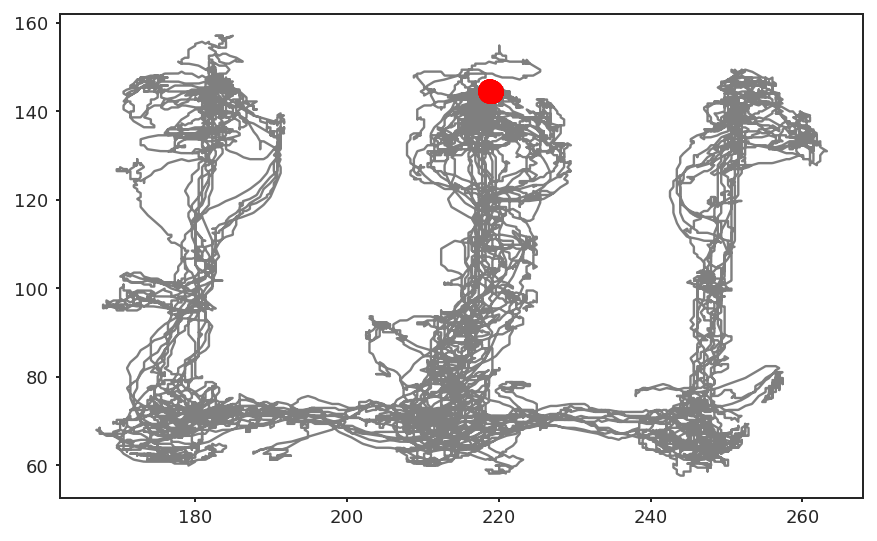

In [11]:
plt.plot(position_2D.x_position, position_2D.y_position, color="black", alpha=0.5)
plt.plot(
    ripple_position_info.x_position,
    ripple_position_info.y_position,
    color="red",
    marker="o",
    markersize=10,
)

### 1D Clusterless Classifier

In [11]:
clusterless_classifier_1D = ClusterlessClassifier(
    place_bin_size=place_bin_size,
    movement_var=movement_var,
    replay_speed=replay_speed,
    discrete_transition_diag=discrete_diag,
    continuous_transition_types=continuous_transition_types,
    model=model,
    model_kwargs=model_kwargs,
)
clusterless_classifier_1D.fit(
    position_1D,
    data["multiunit"],
    is_training=is_training,
    track_graph=track_graph,
    center_well_id=center_well_id,
    edge_order=EDGE_ORDER,
    edge_spacing=EDGE_SPACING,
)

ClusterlessClassifier(discrete_transition_diag=0.98, movement_var=6.0,
                      occupancy_kwargs={'bandwidth': array([24., 24., 24., 24.,  6.,  6.])},
                      occupancy_model=<class 'replay_trajectory_classification.misc.NumbaKDE'>,
                      place_bin_size=3.0, replay_speed=1)

In [12]:
time_slice = slice(*data["ripple_times"].loc[ripple_number, ["start_time", "end_time"]])
m = data["multiunit"].sel(time=time_slice)

clusterless_results_1D = clusterless_classifier_1D.predict(m, m.time - m.time[0])

In [13]:
clusterless_results_1D = clusterless_results_1D.assign_coords(
    state=lambda ds: ds.state.to_index().map(TRANSITION_TO_CATEGORY)
)

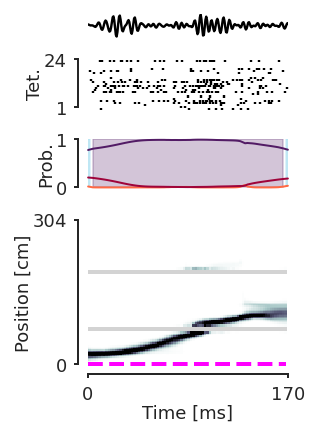

In [15]:
import os

from src.visualization import plot_1D_results
from src.parameters import FIGURE_DIR
from src.figure_utilities import save_figure

plot_1D_results(
    multiunit_times,
    data,
    clusterless_results_1D,
    clusterless_classifier_1D,
    ripple_number,
)

fig_name = (
    "figure2_"
    f"{animal}_{day:02d}_{epoch:02d}_{ripple_number:04d}_"
    f"clusterless_1D_acasual_classification"
)
save_figure(os.path.join(FIGURE_DIR, "Figure2", fig_name))

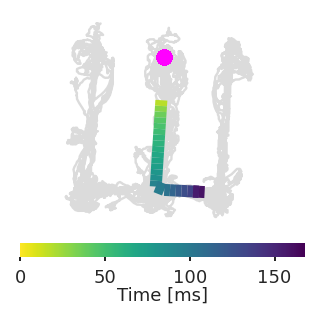

In [16]:
import os
from src.visualization import plot_1D_projected_to_2D
from src.figure_utilities import save_figure
from src.parameters import FIGURE_DIR

plot_1D_projected_to_2D(
    data,
    clusterless_results_1D,
    clusterless_classifier_1D,
    ripple_number,
)

fig_name = (
    "figure2_1D_projected_to_2D_"
    f"{animal}_{day:02d}_{epoch:02d}_{ripple_number:04d}_"
    f"clusterless_1D_acasual_classification"
)
save_figure(os.path.join(FIGURE_DIR, "Figure2", fig_name))

### 1D Sorted Spikes Classifier

In [17]:
from dask.distributed import Client

client = Client(n_workers=4)
client

Client Scheduler: tcp://127.0.0.1:40893 Dashboard: http://127.0.0.1:33703/status,Cluster Workers: 4 Cores: 16 Memory: 16.59 GB


In [18]:
position_1D

time
00:41:01.014800    27.659055
00:41:01.016800    27.606225
00:41:01.018800    27.553396
00:41:01.020800    27.500566
00:41:01.022800    27.447736
                     ...    
00:56:45.006800     7.568632
00:56:45.008800     7.568632
00:56:45.010800     7.568632
00:56:45.012800     7.568632
00:56:45.014800     7.568632
Freq: 2L, Name: linear_position, Length: 472001, dtype: float64

In [19]:
sorted_spikes_classifier_1D = SortedSpikesClassifier(
    place_bin_size=place_bin_size,
    movement_var=movement_var,
    replay_speed=replay_speed,
    discrete_transition_diag=discrete_diag,
    spike_model_penalty=spike_model_penalty,
    knot_spacing=knot_spacing,
    continuous_transition_types=continuous_transition_types,
)
sorted_spikes_classifier_1D.fit(
    position_1D,
    data["spikes"],
    is_training=is_training,
    track_graph=track_graph,
    center_well_id=center_well_id,
    edge_order=EDGE_ORDER,
    edge_spacing=EDGE_SPACING,
)

SortedSpikesClassifier(discrete_transition_diag=0.98, knot_spacing=5,
                       movement_var=6.0, place_bin_size=3.0, replay_speed=1,
                       spike_model_penalty=0.5)

In [20]:
time_slice = slice(ripple_start, ripple_end)
s = data["spikes"].loc[time_slice]
sorted_spikes_results_1D = sorted_spikes_classifier_1D.predict(
    s, time=s.index - s.index[0]
)

In [21]:
sorted_spikes_results_1D = sorted_spikes_results_1D.assign_coords(
    state=lambda ds: ds.state.to_index().map(TRANSITION_TO_CATEGORY)
)

In [22]:
from src.analysis import get_place_field_max

place_field_max = get_place_field_max(sorted_spikes_classifier_1D)
linear_position_order = place_field_max.argsort(axis=0).squeeze()

ordered_spike_times = [spike_times[i] for i in linear_position_order]

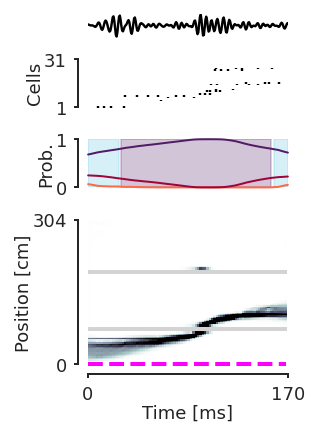

In [23]:
import os

from src.visualization import plot_1D_results
from src.parameters import FIGURE_DIR
from src.figure_utilities import save_figure

plot_1D_results(
    ordered_spike_times,
    data,
    sorted_spikes_results_1D,
    sorted_spikes_classifier_1D,
    ripple_number,
    data_type="sorted_spikes",
)

fig_name = (
    "figure2_"
    f"{animal}_{day:02d}_{epoch:02d}_{ripple_number:04d}_"
    f"sorted_spikes_1D_acasual_classification"
)
save_figure(os.path.join(FIGURE_DIR, "Figure2", fig_name))

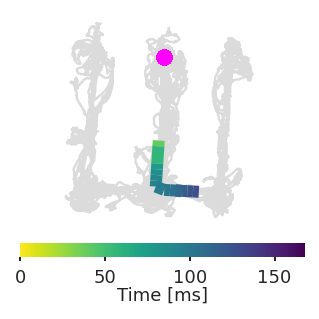

In [24]:
import os
from src.visualization import plot_1D_projected_to_2D
from src.figure_utilities import save_figure
from src.parameters import FIGURE_DIR

plot_1D_projected_to_2D(
    data,
    sorted_spikes_results_1D,
    sorted_spikes_classifier_1D,
    ripple_number,
)

fig_name = (
    "figure2_1D_projected_to_2D_"
    f"{animal}_{day:02d}_{epoch:02d}_{ripple_number:04d}_"
    f"sorted_spikes_1D_acasual_classification"
)
save_figure(os.path.join(FIGURE_DIR, "Figure2", fig_name))

In [ ]:
# from src.figure_utilities import save_figure

# fig, ax = plt.subplots(figsize=(1, 3))
# ax.set_visible(False)
# cax = plt.colorbar(
#     plt.gcf(),
#     orientation="horizontal",
#     ax=ax,
#     extend="max",
#     ticks=h.colorbar.get_clim(),
#     label="Posterior",
# )
# cax.ax.set_xticklabels([0, "Max"])
# # save_figure("figure2_colorbar")

In [25]:
from src.visualization import make_classifier_movie
import os
import xarray as xr

animal, day, epoch = epoch_key
data_type, dim = "clusterless", "1D"

model_name = os.path.join(
    PROCESSED_DATA_DIR, f"{animal}_{day:02}_{epoch:02}_{data_type}_{dim}_model.pkl"
)

classifier = ClusterlessClassifier.load_model(model_name)

results = xr.open_dataset(
    os.path.join(PROCESSED_DATA_DIR, f"{animal}_{day:02d}_{epoch:02d}.nc"),
    group=f"/{data_type}/{dim}/classifier/ripples/",
)

make_classifier_movie(classifier, results, ripple_number, data, epoch_key)

RuntimeError: Requested MovieWriter (ffmpeg) not available